# MSDS 422 Assignment 4 Part 2

In [178]:
#Import Packages
import os
import time
import numpy as np
import pandas as pd
import glob
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [202]:
#Read Data
train = pd.read_csv("Downloads/disaster_train.csv")
test = pd.read_csv("Downloads/disaster_test.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [180]:
#Examine data/check for missing values
print(train.shape)
train.isna().sum()

(7613, 5)


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [181]:
#Save ID column for kaggle submission
test_id = test['id']

In [182]:
#Split Data into Train/Test set
X_train, X_test, y_train, y_test = train_test_split(train['text'], train['target'], test_size=0.2, random_state=42)

## Model 1: Word Embeddings while Training

In [183]:
#10,000 words will be kept
vocab_size = 10000
#Max length of token word
max_length = 50
#Removes values at end of sequence if over max_length
trunc_type='post'
#Used to replace out of vocab words
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

In [184]:
print(f'Train padded shape: {padded.shape}')
print(f'Test padded shape: {testing_padded.shape}')

Train padded shape: (6090, 50)
Test padded shape: (1523, 50)


In [185]:
# Model with LSTM
start1 = time.time()
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

#history_lstm = model1.fit(padded, y_train, epochs=30, validation_data=(testing_padded, y_test), verbose=0)
end1 = time.time()
time1 = end1-start1

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 64)          640000    
                                                                 
 lstm_21 (LSTM)              (None, 64)                33024     
                                                                 
 dense_37 (Dense)            (None, 64)                4160      
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 677,249
Trainable params: 677,249
Non-trainable params: 0
_________________________________________________________________


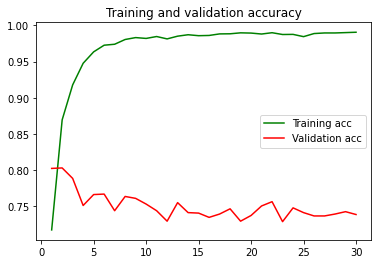

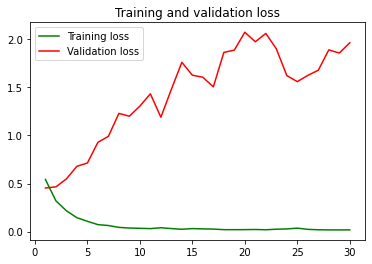

In [186]:
acc1 = history_lstm.history['accuracy']
val_acc1 = history_lstm.history['val_accuracy']
loss1 = history_lstm.history['loss']
val_loss1 = history_lstm.history['val_loss']
epochs = range(1, len(acc1) + 1)
plt.plot(epochs, acc1, 'g', label='Training acc')
plt.plot(epochs, val_acc1, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss1, 'g', label='Training loss')
plt.plot(epochs, val_loss1, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

## Model 2: Pre-Trained Word Embeddings

In [187]:
#Open Glove File
embeddings_dictionary = dict()
embedding_dim = 300
vocab_length = len(word_index) + 1

glove_file = open('Downloads/glove.twitter.27B.100d.txt', 'rb')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [188]:
#Create embedding matrix
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [189]:
#Check Shape
print(f'Shape of Embedding: {embedding_matrix.shape}')

Shape of Embedding: (19461, 300)


In [190]:
#Model using pre-trained Glove embeddings
start2 = time.time()
model2 = tf.keras.Sequential()
model2.add(
    tf.keras.layers.Embedding(
        input_dim=embedding_matrix.shape[0],output_dim=embedding_matrix.shape[1], weights=[embedding_matrix],
        input_length=max_length, trainable = False
    )
)
model2.add(tf.keras.layers.LSTM(64))
model2.add(tf.keras.layers.Dense(64, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])
    
model2.summary()

num_epochs = 10
#history_glove = model2.fit(padded, y_train, epochs=30, validation_data=(testing_padded, y_test), verbose=0)
end2 = time.time()
time2 = end2-start2

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 50, 300)           5838300   
                                                                 
 lstm_22 (LSTM)              (None, 64)                93440     
                                                                 
 dense_39 (Dense)            (None, 64)                4160      
                                                                 
 dense_40 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,935,965
Trainable params: 97,665
Non-trainable params: 5,838,300
_________________________________________________________________


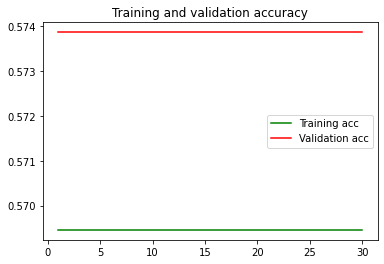

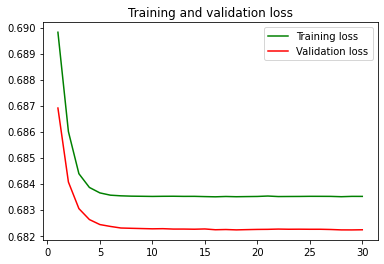

In [191]:
acc2 = history_glove.history['accuracy']
val_acc2 = history_glove.history['val_accuracy']
loss2 = history_glove.history['loss']
val_loss2 = history_glove.history['val_loss']
epochs = range(1, len(acc2) + 1)
plt.plot(epochs, acc2, 'g', label='Training acc')
plt.plot(epochs, val_acc2, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss2, 'g', label='Training loss')
plt.plot(epochs, val_loss2, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show();

## Model Comparison

In [192]:
df = {"Model Name": ["Model 1","Model 2 (Glove)"],
      "Training Time": [time1, time2],
      "Loss (Training)": [loss1[-1],loss2[-1]],
      "Loss (Validation)": [val_loss1[-1],val_loss2[-1]],
      "Accuracy (Training)": [acc1[-1],acc2[-1]],
      "Accuracy (Validation)": [val_acc1[-1],val_acc2[-1]]
     }
df = pd.DataFrame(df)
display(df)

,Model Name,Training Time,Loss (Training),Loss (Validation),Accuracy (Training),Accuracy (Validation)
0,Model 1,214.574985,0.01791,1.963922,0.990476,0.738674
1,Model 2 (Glove),428.725454,0.68351,0.682226,0.569458,0.573867


In part 2 of this assignment, two RNN models were constructed to classify Tweets as relating to disasters or not. Model 1 is an RNN built using LSTM architecture. 10,000 words were chosen to be kept from the collection of tweets in the training set. Punctuation is removed using a Keras Tokenizer and padding is used to maintain a standardlength between sequences. In Model 2, pre-trained word embeddings are used to classify tweets, as opposed to Model 1 where the word embeddings took place during training. 

From the graph outputs of loss/accuracy we see some issues with both models. Model 1 appears to suffer from overfitting; validation accuracy starts are around 0.8 but drops to 0.75 while the training accuracy improved to 0.986. There seems to be something wrong with Model 2 because the output for training and test data is the exact same for accuracy and loss. The numbers for these metrics also indicate that Model 2 is not a good classifier of tweets. 

Model 1 has a high enough accuracy rate to be used for Kaggle predictions. Model 1 will be used for the submission.  

In [193]:
sample_submission = pd.read_csv("Downloads/sample_submission.csv")

In [203]:
tokenizer.fit_on_texts(test['text'])
sequences = tokenizer.texts_to_sequences(test['text'])
testing_padded = pad_sequences(sequences, maxlen=max_length)

In [215]:
predict=model1.predict(testing_padded)
predict=np.round(predict).astype(int).reshape(3263)
submission = pd.DataFrame()
submission['id'] = test['id']
submission['target'] = predict
submission.to_csv("Disaster Predictions.csv", index=False)

102/102 [==============================] - 1s 11ms/step
